In [61]:
# BEFORE RUNNING THE CELLS, PLEASE GO TO "EDIT" -> "NOTEBOOK SETTINGS" -> AND SET "HARDWARE ACCELERATOR" TO GPU

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dropout, Flatten, Dense, Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dropout
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

import numpy as np 
import matplotlib.pyplot as plt 
import argparse
import os
import cv2 
import random

import sys
from PIL import Image

import pickle

import math



In [2]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
!unzip '/content/drive/MyDrive/254 Project/finaldata.zip'


Streaming output truncated to the last 5000 lines.
  inflating: finaldata/Interesting/S3467_B25_States6_Interesting_Sample8_105.png  
  inflating: finaldata/Interesting/S3467_B25_States6_Interesting_Sample8_106.png  
  inflating: finaldata/Interesting/S3467_B25_States6_Interesting_Sample8_107.png  
  inflating: finaldata/Interesting/S3467_B25_States6_Interesting_Sample8_108.png  
  inflating: finaldata/Interesting/S3467_B25_States6_Interesting_Sample8_109.png  
  inflating: finaldata/Interesting/S3467_B25_States6_Interesting_Sample8_110.png  
  inflating: finaldata/Interesting/S3467_B25_States6_Interesting_Sample8_111.png  
  inflating: finaldata/Interesting/S3467_B25_States6_Interesting_Sample8_112.png  
  inflating: finaldata/Interesting/S3467_B25_States6_Interesting_Sample8_113.png  
  inflating: finaldata/Interesting/S3467_B25_States6_Interesting_Sample8_114.png  
  inflating: finaldata/Interesting/S3467_B25_States6_Interesting_Sample8_115.png  
  inflating: finaldata/Interesting/S

In [5]:
DATADIR = "./finaldata" 
CATEGORIES = ["Boring", "Interesting"]
training_data = []
IMG_SIZE = 300 # Hyperparameter. calculated to be stitched together size. each img is 396 x 396. Stitching them together 396*3 = 1188x 1188. So 1185 is an approximation of that.

In [7]:
## Stitch the images together 
## 0 1 2 
## 3 4 5
## 6 7 8

def stitch_images(file_path, file_name):
    images = [Image.open(image) for image in [file_path + "/" + file_name + str(x) + ".png" for x in range(100, 109)]]
    widths, heights = zip(*(i.size for i in images))
    total_width = int(sum(widths) / 3)
    total_height = int(sum(heights) / 3)
    new_image = Image.new("RGB", (total_width, total_height))
    for index in range(0, 9):
        image = images[index]
        new_image.paste(image, ((index % 3) * image.size[0], math.floor(index / 3) * image.size[1]))

    IMAGE_DIR = os.path.join(file_path, "combined/") + file_name + "combined.png"
    new_image.save(IMAGE_DIR)
    return IMAGE_DIR

In [8]:
def create_training_data():
    for category in CATEGORIES: 
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for image in sorted(os.listdir(path)): 
            if "100" not in image: ## Find the starting frame
                continue
            IMAGE_DIR = stitch_images(path, image[0:-7])
            # The following snippet to reduce data size
            try: 
                img_array = cv2.imread(IMAGE_DIR, cv2.IMREAD_GRAYSCALE) #cv2.IMREAD_GRAYSCALE: It specifies to load an image in grayscale mode. Alternatively, we can pass integer value 0 for this flag.
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                training_data.append([new_array, class_num])
            except Exception as e: 
                pass 

In [10]:
# Be sure to create two 'combined' folders and put one in each of 'Boring' and 'Interesting'

create_training_data() 
random.shuffle(training_data) 

In [11]:
X, y = [], []
for features, label in training_data: 
    X.append(features)
    y.append(label)
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y = np.array(y)

In [12]:
print(X.shape)

(2100, 300, 300, 1)


In [13]:
X = X.astype('float32')
X = X / 255.0

0.0
Baseline =  0.5
2100


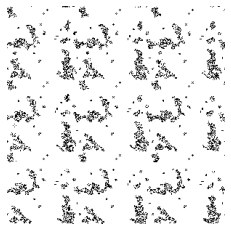

In [28]:
print(np.min(X))
plt.imshow(X[12].reshape(IMG_SIZE, IMG_SIZE), cmap='gray');
plt.axis('off')
plt.savefig('stitched_image.png')
print('Baseline = ', np.sum(y)/len(y) )
print(len(y))

In [36]:
# Split X, y into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42) 

In [64]:
# Train on training data only
model2 = keras.Sequential()
model2.add(Conv2D(64, (5, 5), input_shape=X.shape[1:]))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.15))

model2.add(Conv2D(64, (3, 3)))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.15))

model2.add(Flatten())
model2.add(Dense(64))
model2.add(Activation("relu"))
model2.add(Dropout(0.15))

model2.add(Dense(10))
model2.add(Activation("relu"))
model2.add(Dropout(0.15))

model2.add(Dense(1))
model2.add(Activation("sigmoid"))

model2.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

with tf.device('/device:GPU:0'):
  model2.fit(X_train, y_train, batch_size=2, epochs=20, verbose = 1) 

Epoch 1/20
945/945 [==============================] - 20s 21ms/step - loss: 10.1372 - accuracy: 0.6302
Epoch 2/20
945/945 [==============================] - 20s 21ms/step - loss: 0.7416 - accuracy: 0.5101
Epoch 3/20
945/945 [==============================] - 20s 21ms/step - loss: 0.6976 - accuracy: 0.5037
Epoch 4/20
945/945 [==============================] - 20s 22ms/step - loss: 0.7674 - accuracy: 0.5444
Epoch 5/20
945/945 [==============================] - 20s 21ms/step - loss: 0.7635 - accuracy: 0.6307
Epoch 6/20
945/945 [==============================] - 20s 21ms/step - loss: 0.8028 - accuracy: 0.7153
Epoch 7/20
945/945 [==============================] - 20s 21ms/step - loss: 0.8282 - accuracy: 0.7534
Epoch 8/20
945/945 [==============================] - 20s 21ms/step - loss: 0.8868 - accuracy: 0.7899
Epoch 9/20
945/945 [==============================] - 20s 21ms/step - loss: 0.7981 - accuracy: 0.8238
Epoch 10/20
945/945 [==============================] - 20s 21ms/step - loss: 0.84

In [1]:
# Split X, y into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42) 

# Reduce positive values to ~10% of data

# Find indices where y_test is interesting
y_test_bool = y_test == 1
num_true = 0
delete_mask = []
for i in range(0, len(y_test)):
  if y_test_bool[i] == True:
    num_true += 1
    if num_true > 15:
      delete_mask.append(i)
      

y_test = np.delete(y_test, delete_mask, 0)
X_test = np.delete(X_test, delete_mask, 0)
print(X_test.shape)
print(np.sum(y_test))

NameError: ignored

In [69]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Do an accuracy test on data with only ~10% interesting claseses
print('Accuracy on test---')
y_pred_test=model2.predict_classes(X_test)
print(accuracy_score(y_test,y_pred_test))
print(recall_score(y_test,y_pred_test))

Accuracy on test---
0.8412698412698413
1.0
